In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
import torch
from scipy.special import softmax

class Sequence:
    def __init__(self):
        # (50,51) are wild jacks
        # (48,49) are anti-wild jacks
        self.deck = np.hstack((np.arange(52),np.arange(52),np.ones(4)*-1))

        #represent the current state of the game
        # 0 represents an empty space
        # 1 represents a space with a black token
        # -1 represents a space with a white token
        self.tokens = np.zeros((10,10))

        #randomly assign spaces on the board to cards.
        board = np.random.choice(self.deck[self.deck<48],len(self.deck)-8,replace=False).reshape(10,10)
        #board = np.concatenate((np.random.choice(self.deck[self.deck<48],len(self.deck)-8,replace=False),
        #                        [-1]*4)).reshape(10,10)
        #board[9,-4:-1] = [board[0,0],board[0,9],board[9,0]]
        #board[0,0],board[0,9],board[9,0] = (-1,-1,-1)
        self.board = board

        
        #draw cards for players
        np.random.shuffle(self.deck)
        self.deck_pos = len(self.deck)-1
        self.hands = [self.deck[-5:],self.deck[-10:-5]]
        self.deck_pos -= 10
        self.turn = 1

        self.kernels = [np.diag(np.ones(5)),
                        np.flip(np.diag(np.ones(5)),axis=0),
                        np.ones(5).reshape(5,-1),
                        np.ones(5).reshape(-1,5)]

    
    def play(self, play):
        """
        Parameters:
            play (tuple (int,(int,int)) ): play represented by card from hand and location on the board
            player (int): which player is making the move? -1 or 1
        """
        #if legal move
        
        #place or remove token
        if self.hands[(self.turn+1)//2][play[0]] in [48,49]:
            self.tokens[play[1][0],play[1][1]] = 0
        else:
            self.tokens[play[1][0],play[1][1]] = self.turn
        
        #draw card

        self.hands[(self.turn+1)//2][play[0]] = self.deck[self.deck_pos]
        self.deck_pos -= 1

        #change turns
        self.turn = -1*self.turn
    
    def show_board(self):
        cmap = plt.get_cmap('RdBu', 3)
        plt.matshow(self.tokens,cmap=cmap,vmin=-1,vmax=1)
        plt.colorbar(ticks=np.arange(-1,2))
        ticks = np.arange(11)-0.5
        plt.xticks(ticks)
        plt.yticks(ticks)
        plt.grid()
        plt.show()

    
    def get_moves(self):
        moves = list()
        j = 0
        for card in self.hands[(self.turn+1)//2]:
            if card<48:
                locs = np.stack(np.where(np.logical_and(self.board==card,self.tokens==0))).T
            elif card < 50:
                locs = np.stack(np.where(self.tokens==(-1*self.turn))).T
            else:
                locs = np.stack(np.where(self.tokens==0)).T
                #need to consider wild card locations
            
            for loc in locs:
                moves.append((j,loc))
            j += 1
        return moves
        
    def check_winner(self):
        if self.deck_pos < -104:
            return 2
        for k in self.kernels:
            conv = convolve2d(self.tokens,k,mode='valid')
            if (conv==5).sum() > 0:
                return 1
            if (conv==-5).sum() > 0:
                return -1
        return 0
    
    def score(self,base=np.e):        
        temp = self.tokens.copy()
        temp[temp==-1] = -5
        bcounts = np.zeros(4)
        for k in self.kernels:
            conv = convolve2d(temp,k,mode='valid')
            for i in range(4):
                bcounts[i] += (conv==(i+1)).sum()
        
        temp = self.tokens.copy()*-1
        temp[temp==-1] = -5
        wcounts = np.zeros(4)
        for k in self.kernels:
            conv = convolve2d(temp,k,mode='valid')
            for i in range(4):
                wcounts[i] += (conv==(i+1)).sum()
        
        weights = np.power(np.ones(4)*base, np.arange(4)+1)
        return (weights @ bcounts - weights @ wcounts)
    
    def try_score(self,play,**kwargs):
        old_board = self.tokens.copy()
        if self.hands[(self.turn+1)//2][play[0]] in [48,49]:
            self.tokens[play[1][0],play[1][1]] = 0
        else:
            self.tokens[play[1][0],play[1][1]] = self.turn
        s = self.score(**kwargs)
        self.tokens = old_board
        return s
    
    def sample_action(self,model,T=30):
        moves = self.get_moves()
        if len(moves)==0:
            return -1, moves
        scores = np.zeros(len(moves))
        for i in range(len(moves)):
            x = self.prepare_input(moves,i)
            scores[i] = model(x.unsqueeze(0)).item()
        p = softmax(scores/T)
        move = np.random.choice(np.arange(len(moves)),p=p)
        return move, moves

    def prepare_input(self,moves,move_ind):
        potential_moves = np.zeros((10,10))
        for m in moves:
            if m[0]!=moves[move_ind][0]:
                if self.hands[(self.turn+1)//2][m[0]] in [48,49]:
                    potential_moves[m[1][0],m[1][1]] = -1
                else:
                    potential_moves[m[1][0],m[1][1]] = 1
        
        np_input = np.stack((potential_moves,self.tokens==self.turn,self.tokens==(self.turn*-1)))
        if self.hands[(self.turn+1)//2][moves[move_ind][0]] in [48,49]:
            np_input[1+(self.turn+1)//2,moves[move_ind][1][0],moves[move_ind][1][1]] = 0
        else:
            np_input[1+(self.turn+1)//2,moves[move_ind][1][0],moves[move_ind][1][1]] = 1
        return torch.from_numpy(np_input).float()
    
    def max_Q(self,model):
        moves = self.get_moves()
        scores = list()
        for m in range(len(moves)):
            x = self.prepare_input(moves,m)
            scores.append(model(x.unsqueeze(0)).item())
        return np.max(scores)

In [72]:
def Q_play(game,print_scores=False):
    moves = game.get_moves()
    scores = np.zeros(len(moves))
    for i in range(len(moves)):
        x = game.prepare_input(moves,i)
        scores[i] = model(x.unsqueeze(0)).item()
    if print_scores:
        print(scores)
    return moves[np.argmax(scores)]

def h_player(game):
    moves = game.get_moves()
    scores = np.zeros(len(moves))
    for i in range(len(moves)):
        scores[i] = game.try_score(moves[i])
    m = moves[np.argmin(scores)]
    return m, np.min(scores)

def h_play(game):
    moves = game.get_moves()
    scores = np.zeros(len(moves))
    for i in range(len(moves)):
        scores[i] = game.try_score(moves[i])*game.turn
    return moves[np.argmax(scores)]

def r_play(game):
    moves = game.get_moves()
    return moves[np.random.choice(np.arange(len(moves)))]

def comp_players(p1,p2,show_board=False):
    game = Sequence()
    i = 0
    while game.check_winner()==0:
        if i%2 == 0:
            move = p1(game)
            game.play(move)
        else:
            move = p2(game)
            game.play(move)
        i += 1
        if show_board:
            game.show_board()
    return game.check_winner()

## Reinforcement Learning: Deep Q-Learning
https://www.analyticsvidhya.com/blog/2019/04/introduction-deep-q-learning-python/

In [31]:
import seq_model
model = seq_model.seq_scorer()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_par = sum([l.numel() for l in model.parameters() if l.requires_grad])
print(f"There are {num_par} parameters in the model.")
print(model)

There are 3987 parameters in the model.
seq_scorer(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc3): Linear(in_features=16, out_features=25, bias=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=25, out_features=1, bias=True)
)


## Pretrain on Heuristic

In [32]:
import copy
from tqdm.notebook import tqdm
num_games = 20
gamma = 0.98


stable_model = copy.deepcopy(model)
stable_model.eval()

for g in tqdm(range(num_games)):
    game = Sequence()
    game_completed = False
    batch = list()
    lab = list()
    while not game_completed:
        move, moves = game.sample_action(model,T=50/(g+1)**0.5)
        if len(moves) == 0:
            break
        a = moves[move]
        x = game.prepare_input(moves,move)
        game.play(a)
        R = game.check_winner()*-100*game.turn
        if R != 0 or game.deck_pos*-1 < len(game.deck):
            game_complete = True
            target = R
        else:
            target = np.tanh(game.score()/100)*100
        batch.append(x)
        lab.append(torch.tensor([target],dtype=torch.float32))
    optimizer.zero_grad()
    Q = model(torch.stack(batch))
    loss = loss_fn(Q, torch.stack(lab))
    loss.backward()
    # Adjust learning weights
    optimizer.step()
    if g % 10 == 0:
        stable_model = copy.deepcopy(model)
        stable_model.eval()

  0%|          | 0/20 [00:00<?, ?it/s]

## RL Training

In [43]:
import copy
from tqdm.notebook import tqdm
num_games = 200
gamma = 0.98


stable_model = copy.deepcopy(model)
stable_model.eval()

for g in tqdm(range(num_games)):
    game = Sequence()
    game_completed = False
    batch = list()
    lab = list()
    while not game_completed:
        move, moves = game.sample_action(model,T=50/(g+1)**0.5)
        if len(moves) == 0:
            break
        a = moves[move]
        x = game.prepare_input(moves,move)
        game.play(a)
        R = game.check_winner()*100
        if R*game.turn < 0 or game.deck_pos*-1 < len(game.deck):
            game_complete = True
            target = R
        else:
            target = R + gamma*game.max_Q(stable_model)
        batch.append(x)
        lab.append(torch.tensor([target],dtype=torch.float32))
    optimizer.zero_grad()
    Q = model(torch.stack(batch))
    loss = loss_fn(Q, torch.stack(lab))
    loss.backward()
    # Adjust learning weights
    optimizer.step()
    if g % 10 == 0:
        stable_model = copy.deepcopy(model)
        stable_model.eval()

  0%|          | 0/200 [00:00<?, ?it/s]

In [42]:
torch.save(model.state_dict(), 'RL.pth')

In [55]:
checkpoint = torch.load('RL.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Test RL Against Random Player

In [56]:
#power analysis
n = int(np.ceil((1.645/.1)**2*.25))

In [57]:
rslts = np.zeros(n)
for i in tqdm(range(n)):
    rslts[i] = comp_players(Q_play,r_play)
rslts = (rslts+1)/2
rslts.mean()

  0%|          | 0/68 [00:00<?, ?it/s]

0.7058823529411765

In [58]:
from scipy.stats import norm
def rand_test(p,n):
    z = (p-.5)/(.25/n)**0.5
    return z, norm.cdf(z)
rand_test(rslts.mean(),len(rslts))

(3.3954987505086622, 0.9996574815673104)

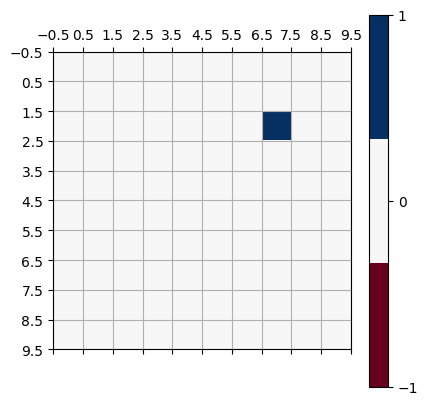

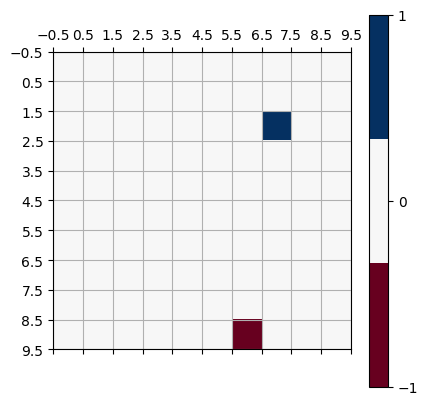

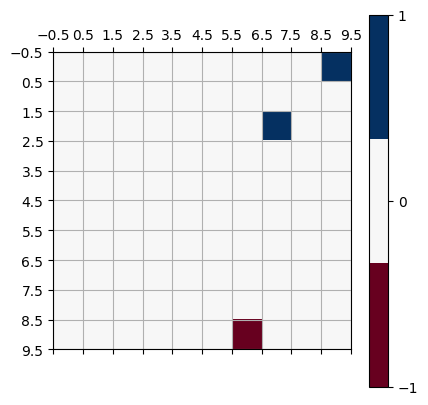

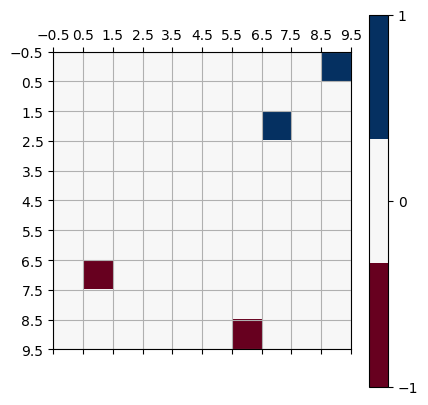

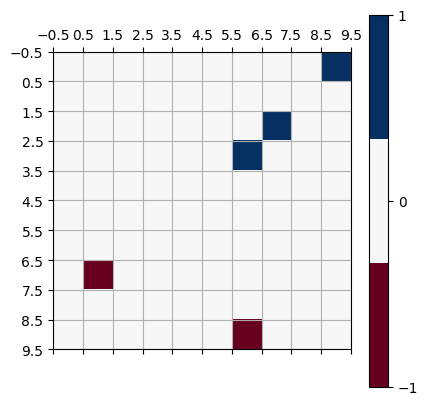

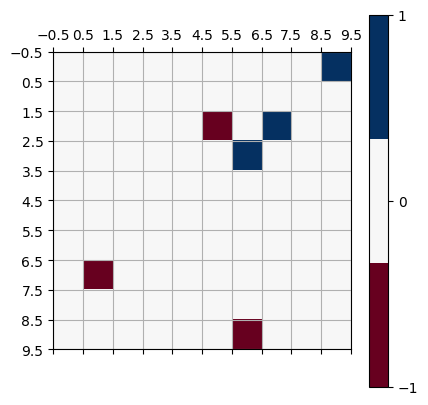

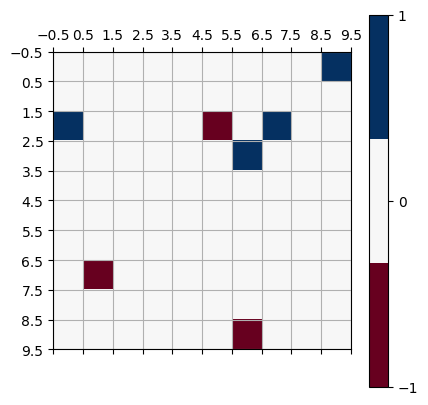

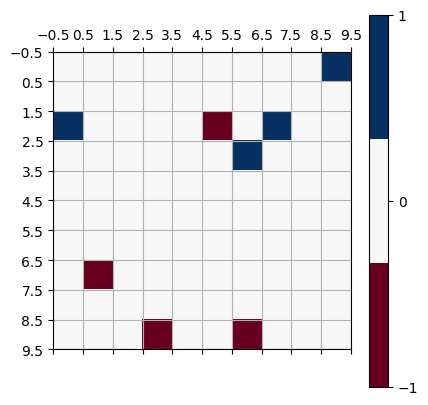

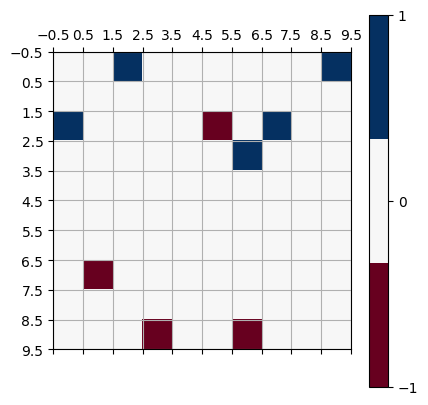

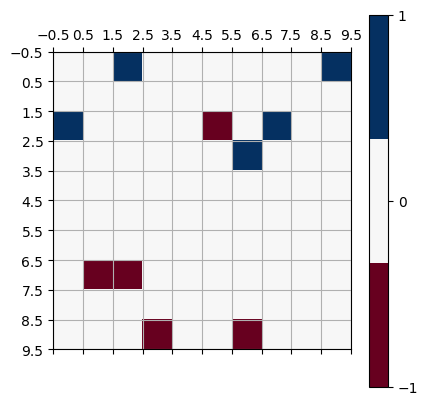

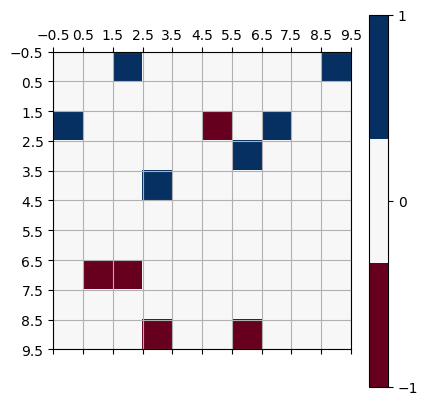

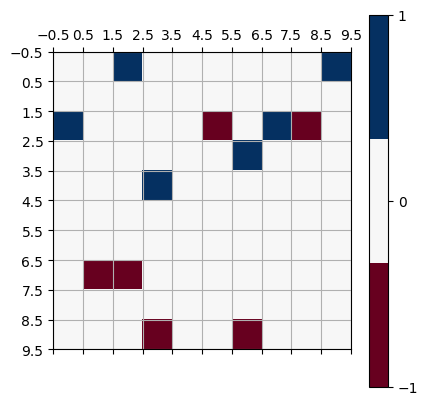

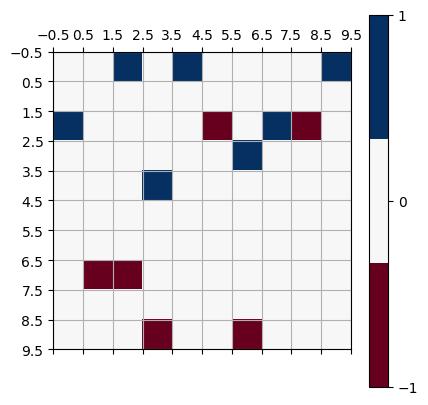

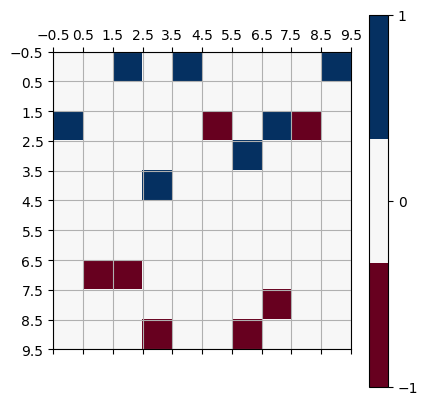

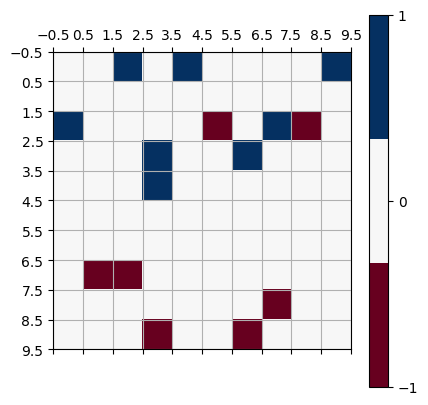

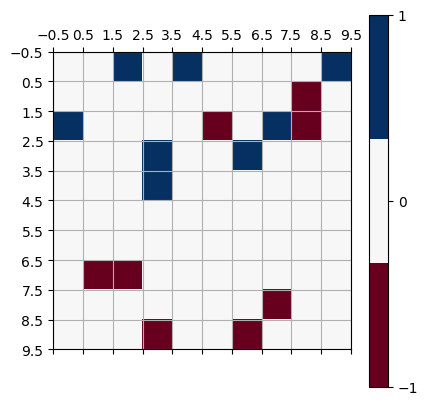

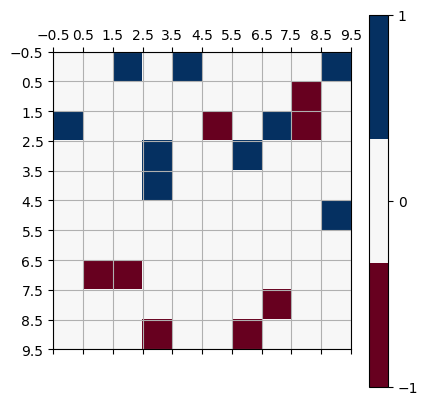

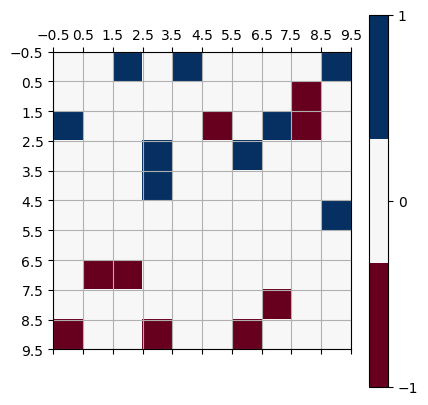

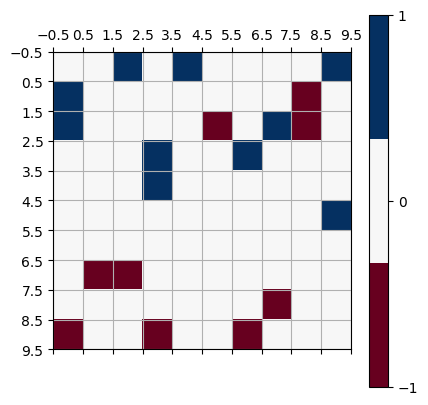

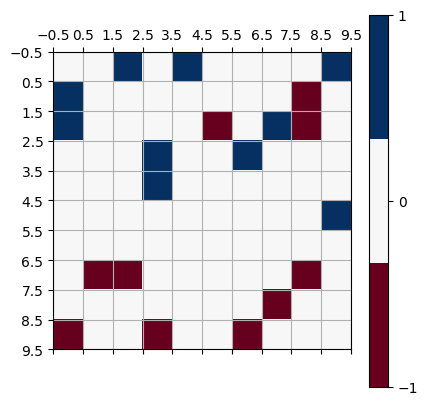

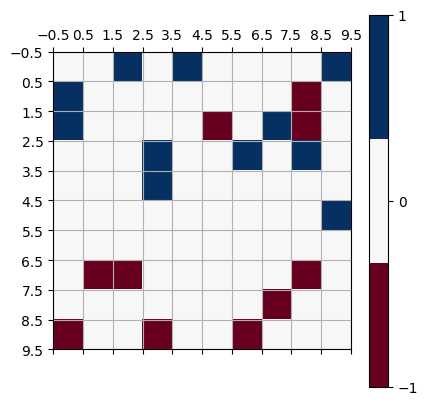

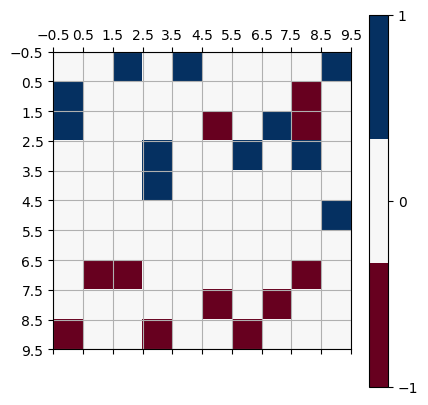

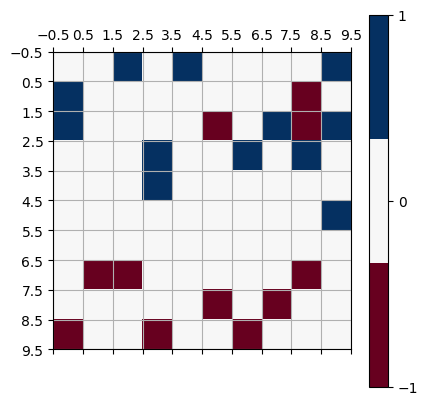

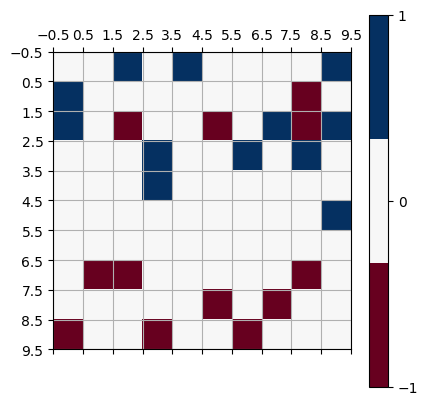

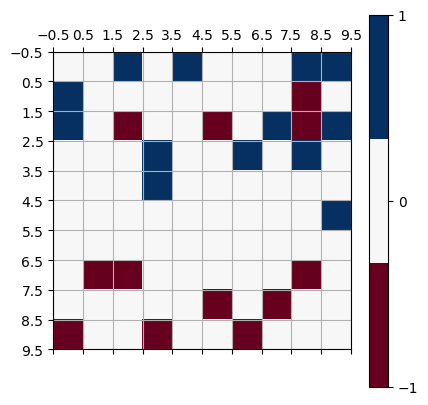

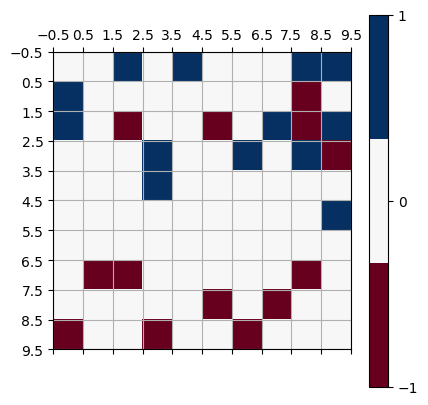

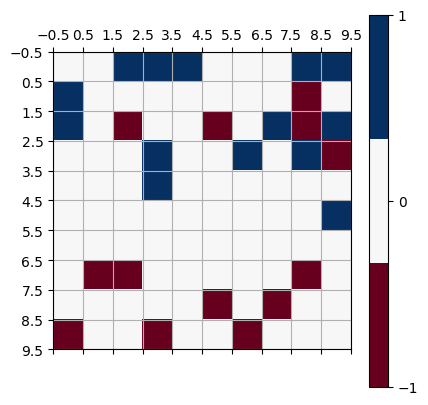

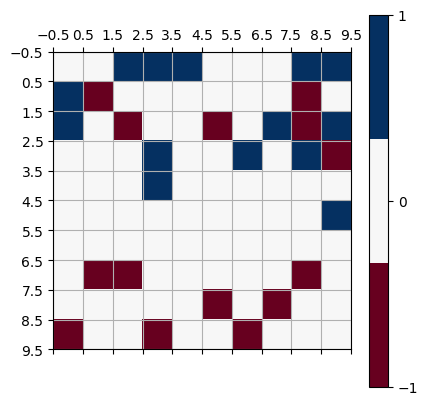

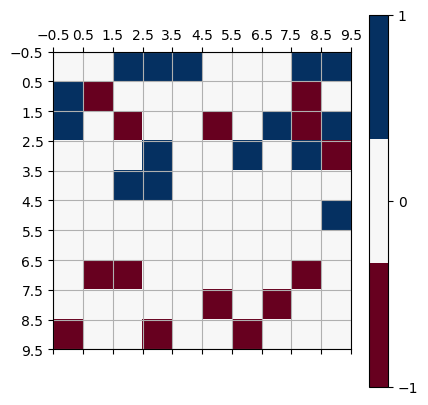

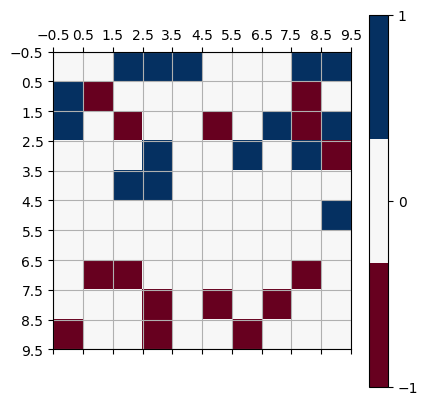

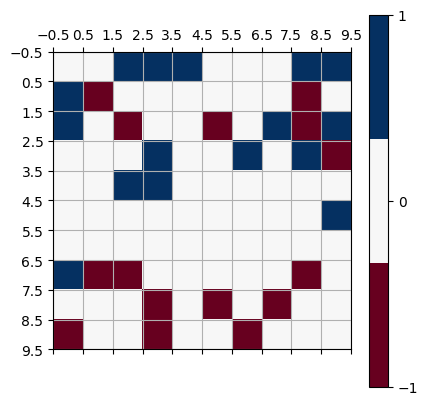

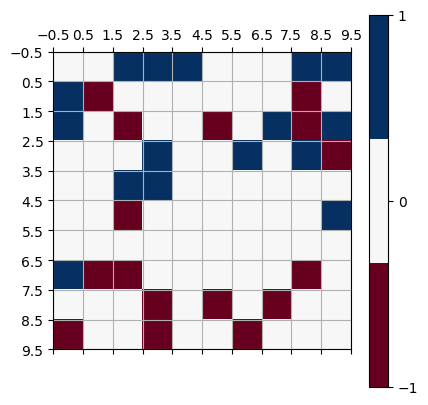

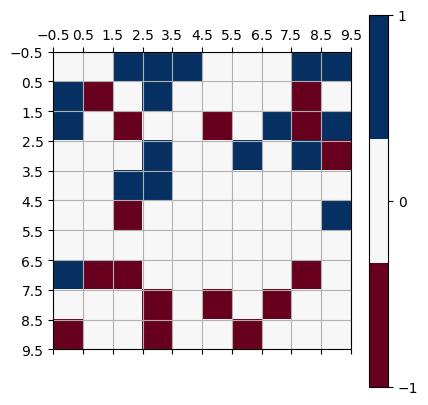

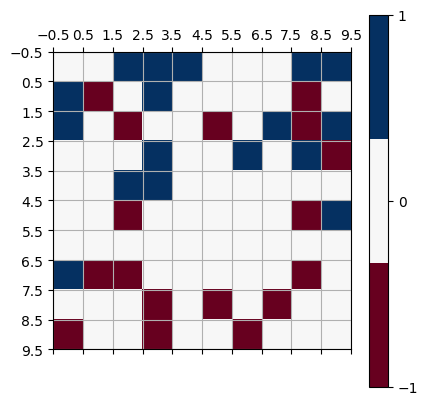

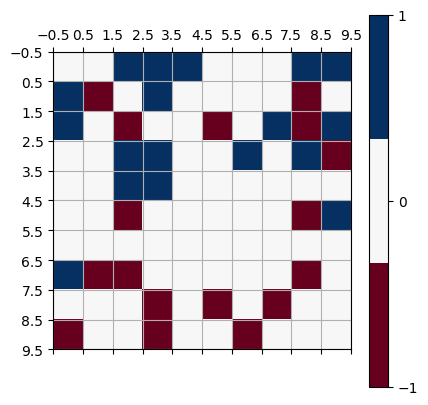

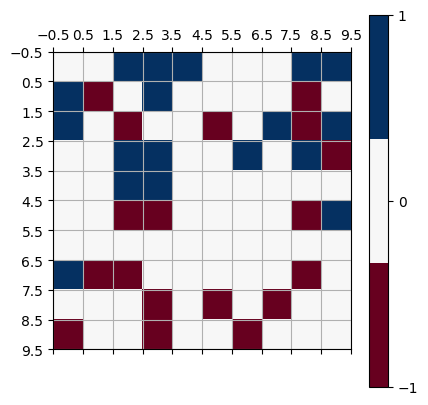

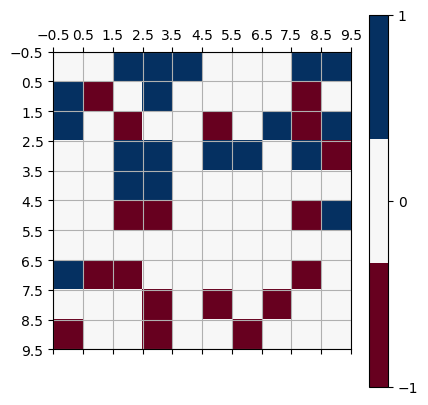

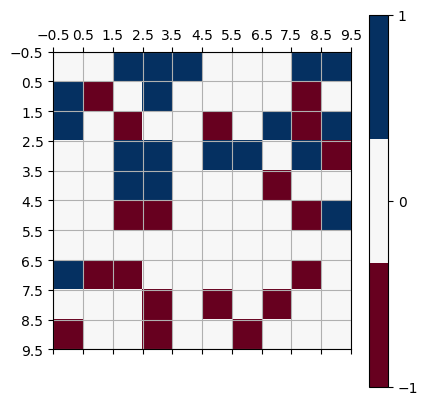

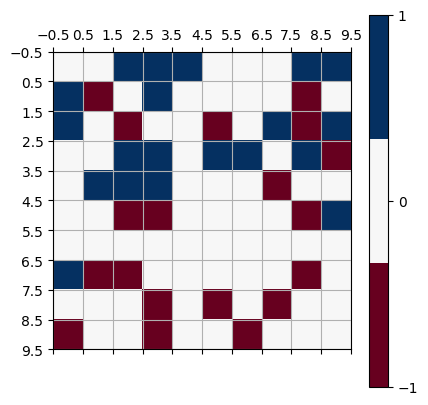

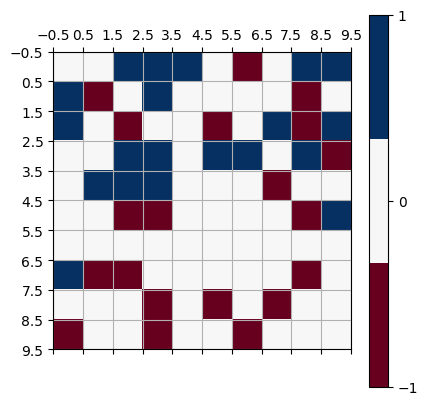

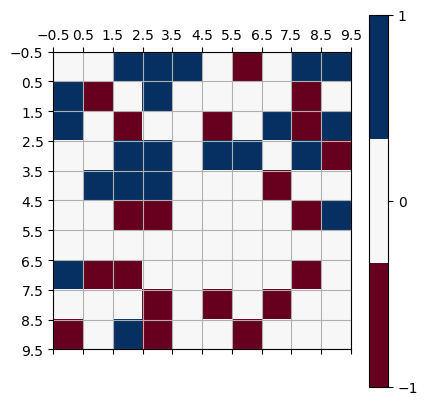

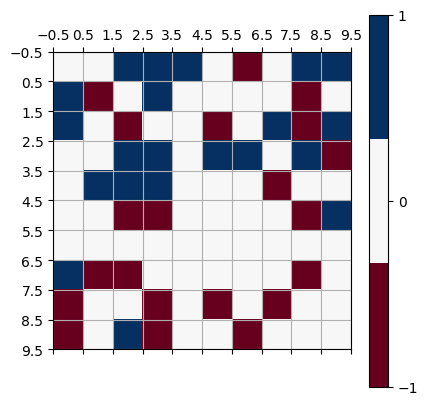

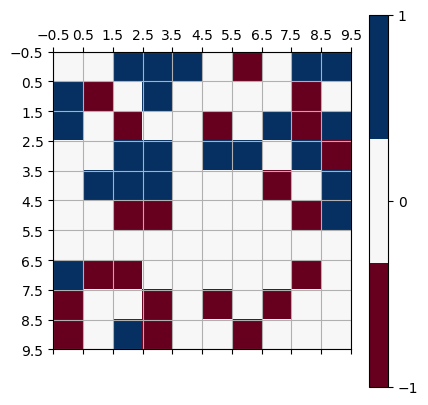

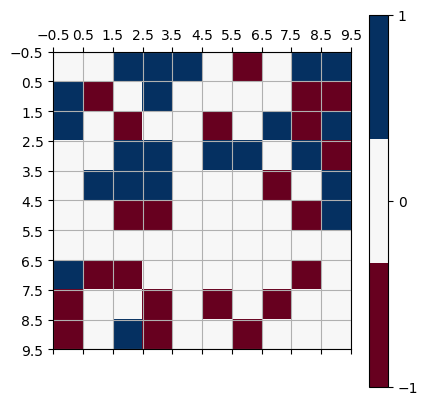

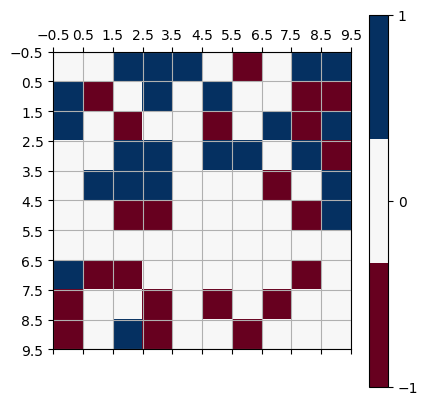

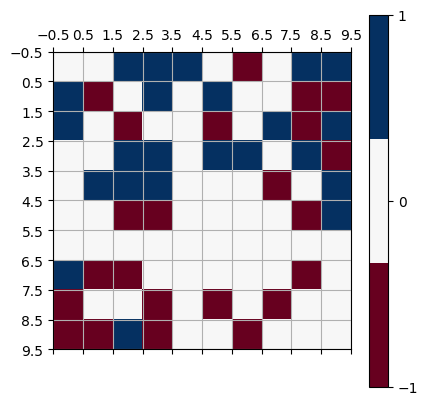

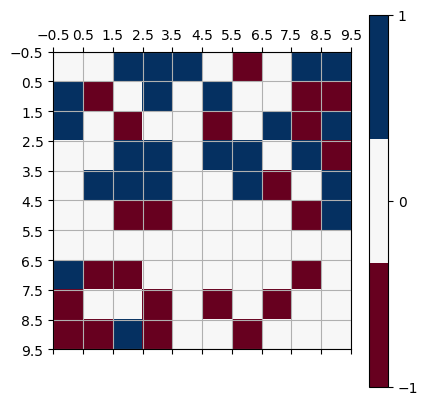

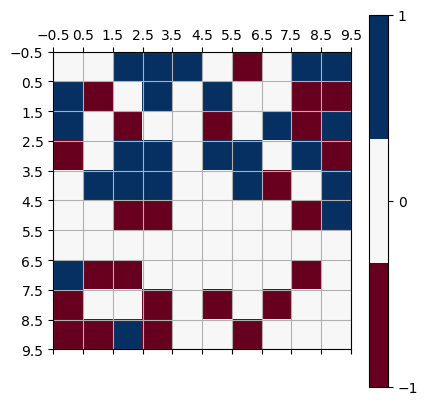

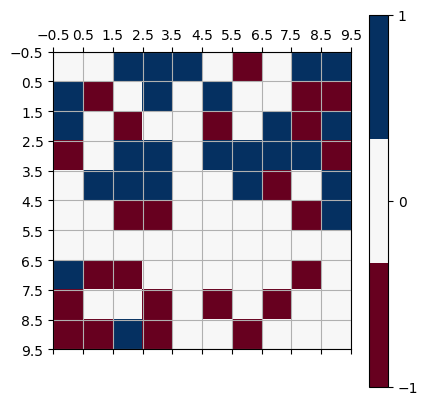

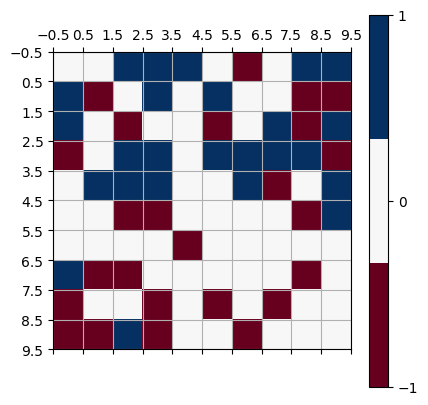

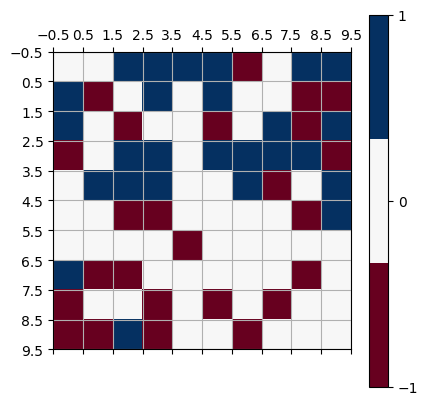

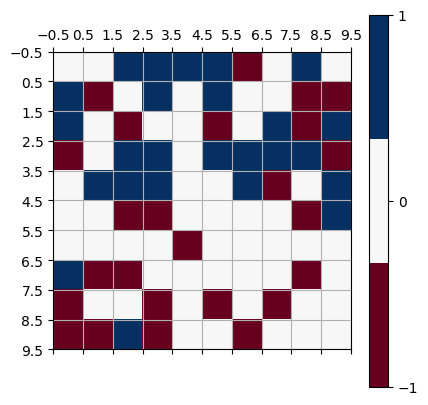

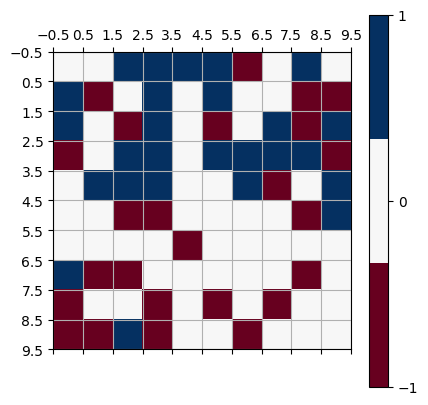

1

In [60]:
#See single game played
comp_players(Q_play,r_play,show_board=True)

## Test Heuristic Player Against Random

In [74]:
rslts = np.zeros(n)
for i in tqdm(range(n)):
    rslts[i] = comp_players(h_play,r_play)
rslts = (rslts+1)/2
rslts.mean()

  0%|          | 0/68 [00:00<?, ?it/s]

0.8235294117647058

In [75]:
rand_test(rslts.mean(),len(rslts))

(5.335783750799325, 0.9999999524336357)

## Test RL Player Against Heuristic

In [76]:
rslts = np.zeros(n)
for i in tqdm(range(n)):
    rslts[i] = comp_players(h_play,Q_play)
rslts = (rslts+1)/2
rslts.mean()

  0%|          | 0/68 [00:00<?, ?it/s]

0.6764705882352942

In [77]:
rand_test(rslts.mean(),len(rslts))

(2.9104275004359965, 0.9981953265320272)

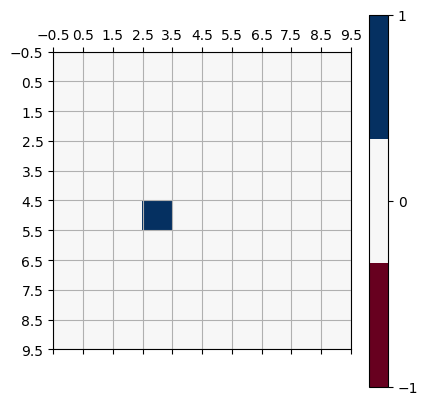

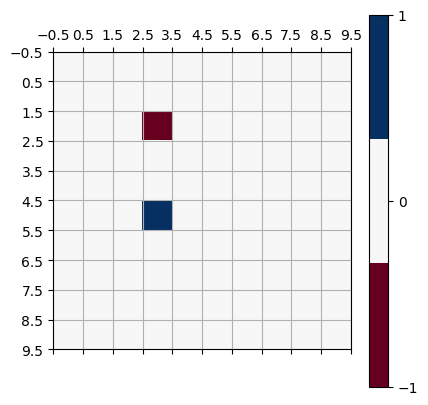

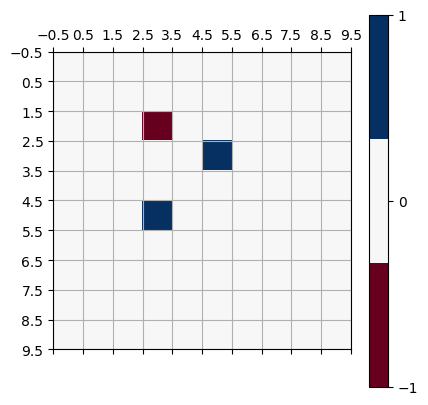

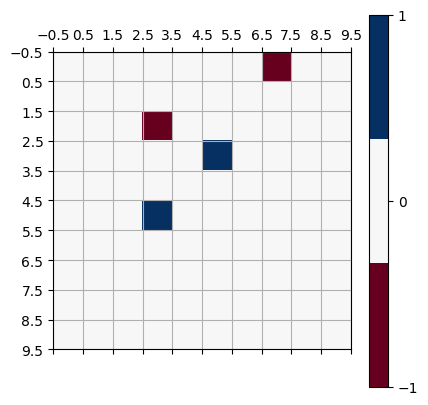

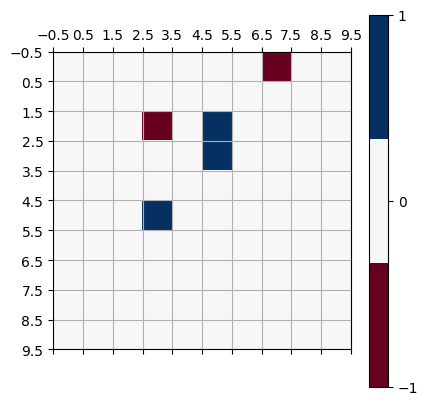

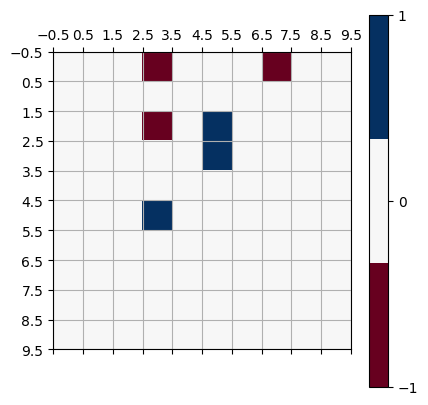

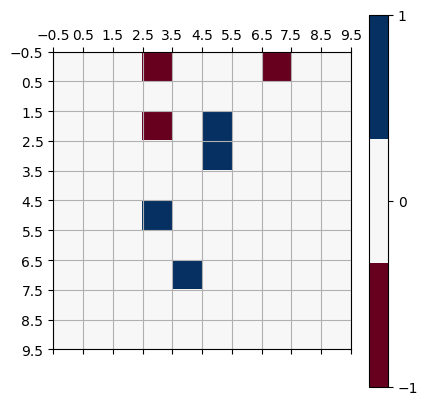

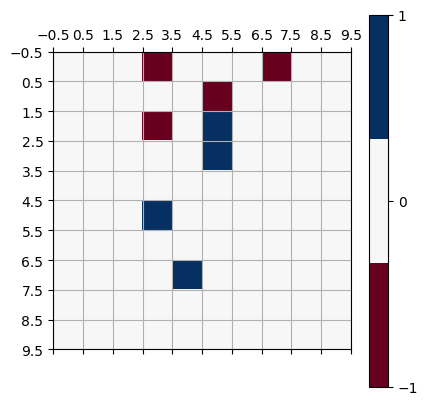

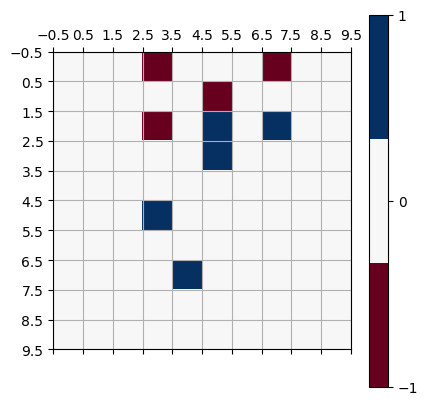

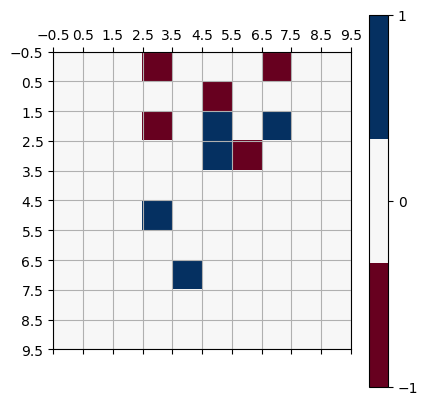

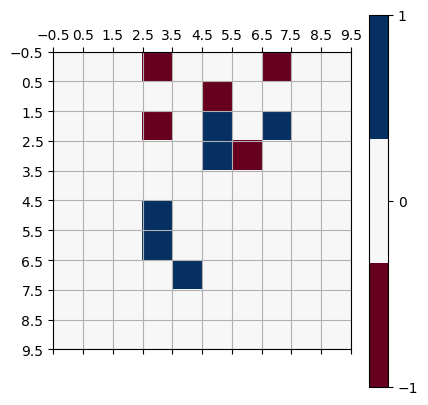

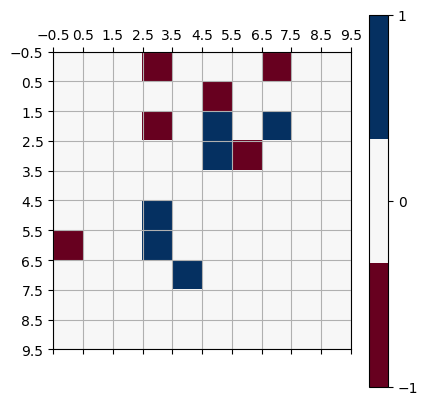

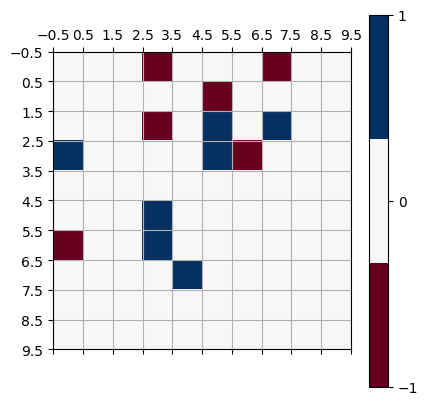

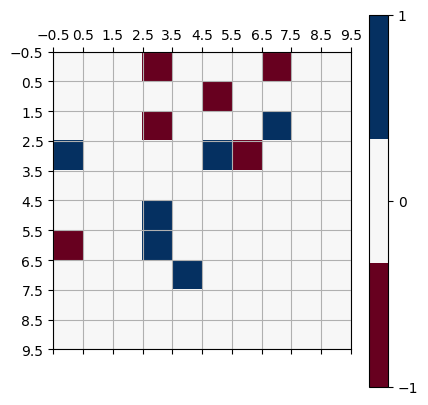

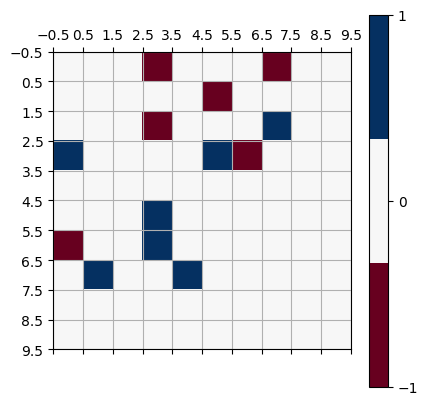

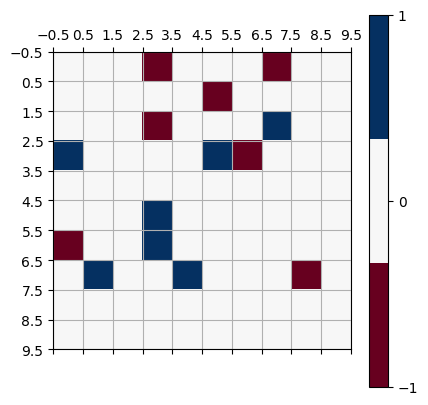

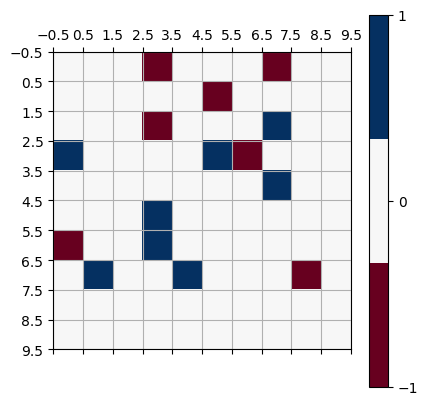

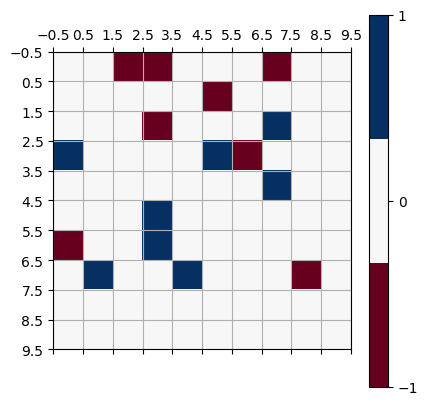

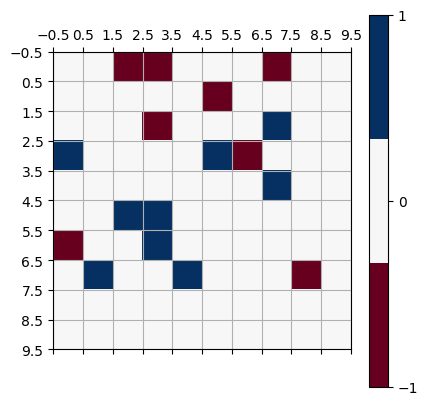

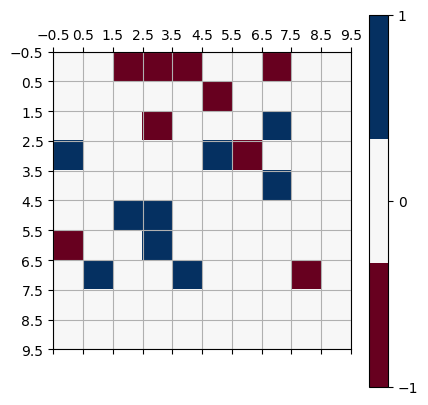

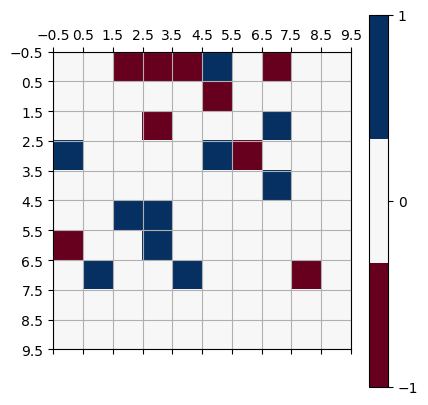

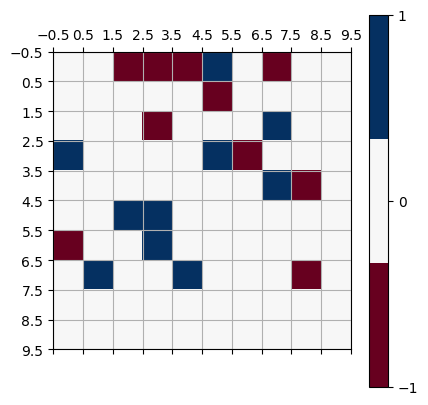

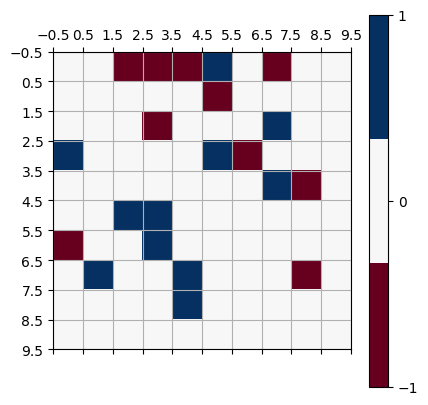

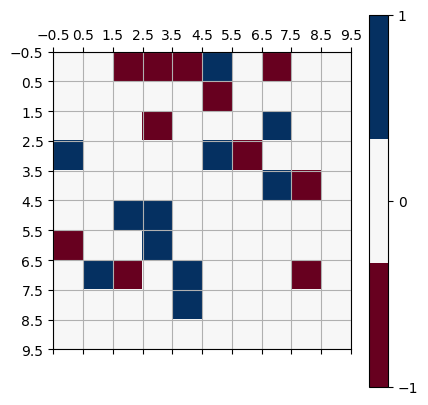

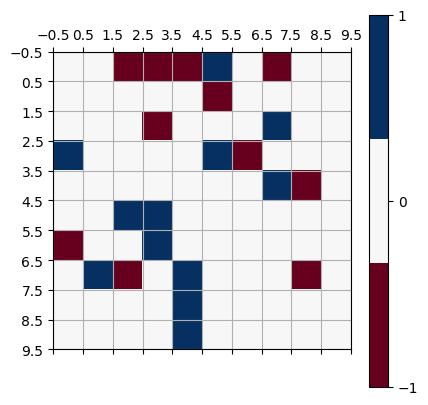

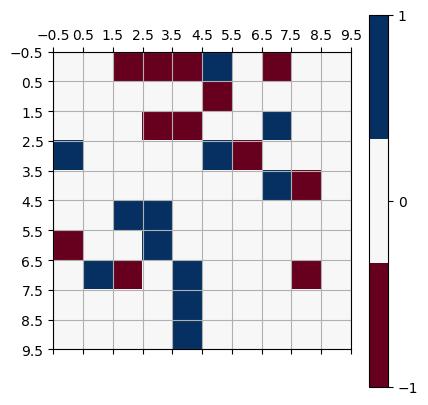

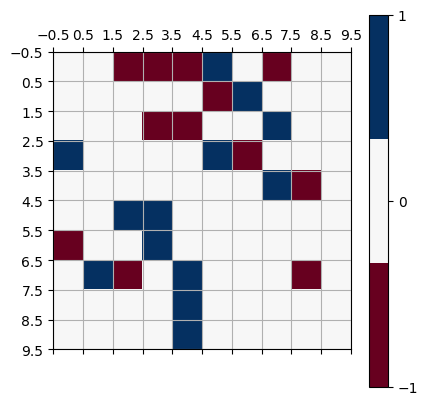

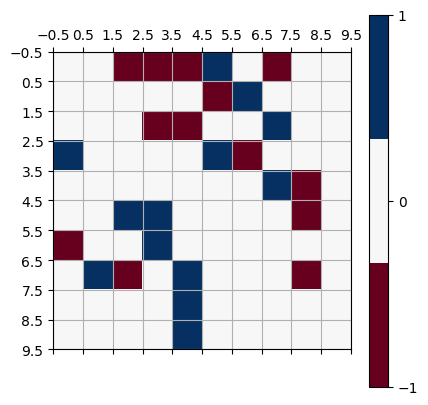

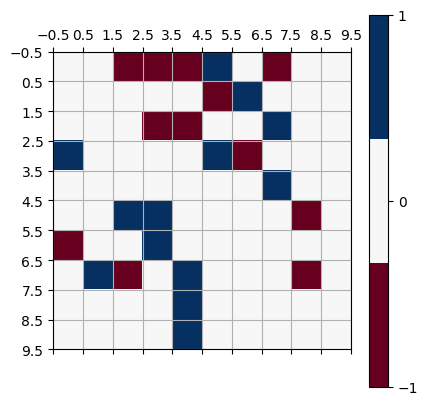

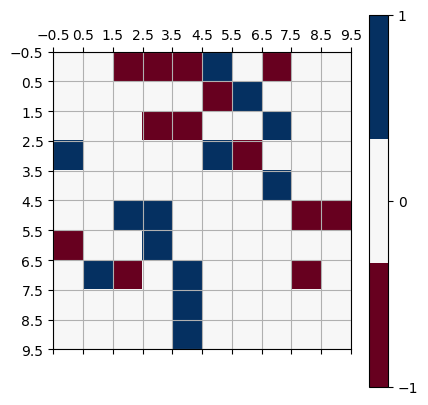

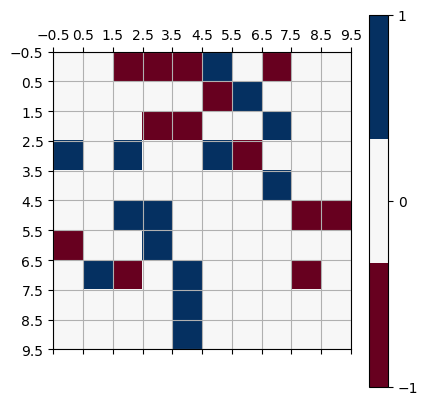

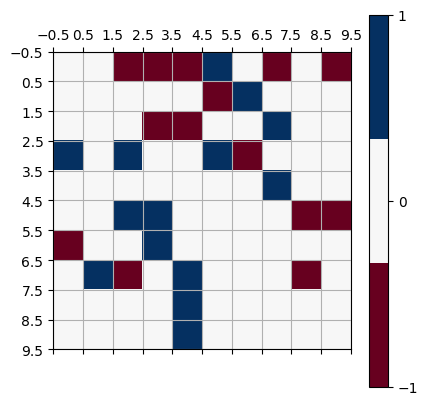

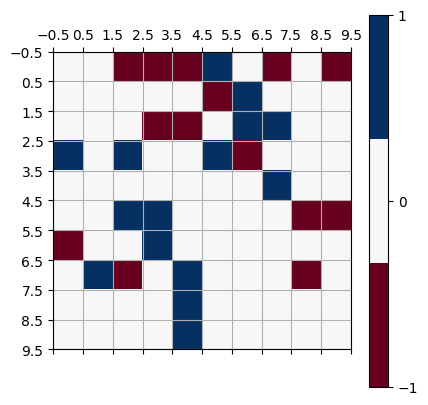

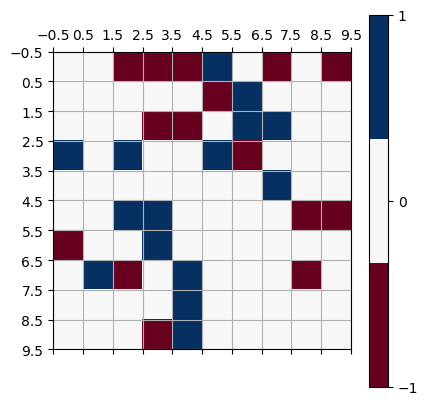

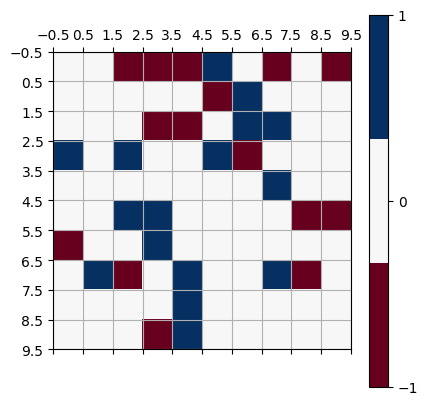

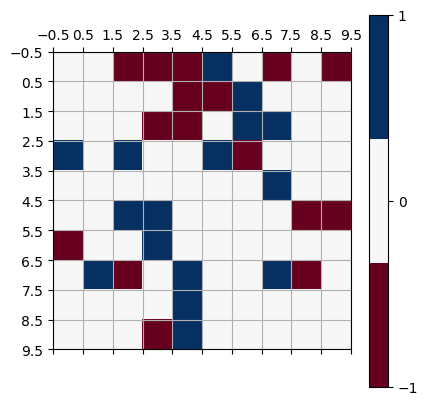

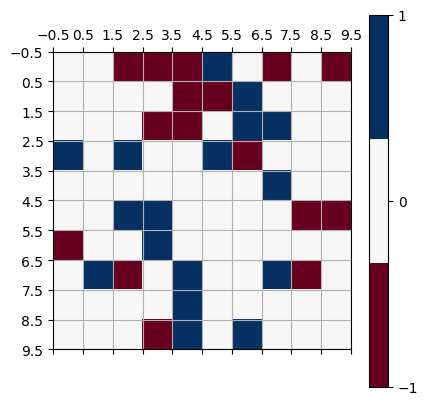

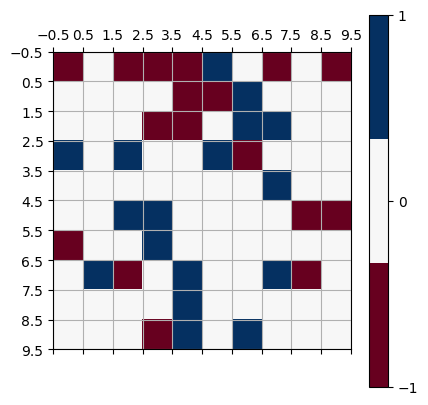

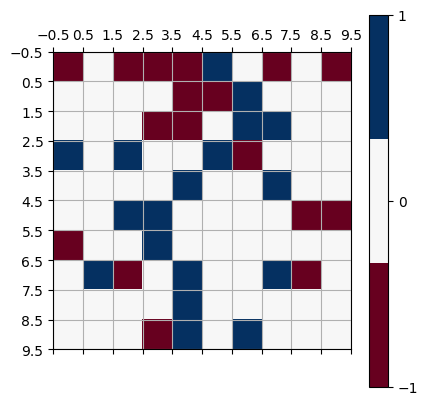

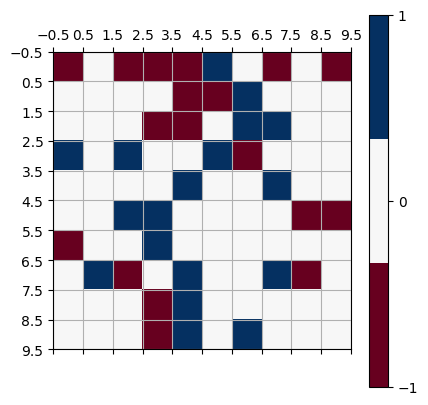

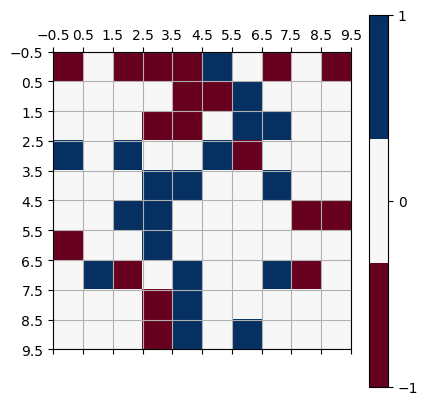

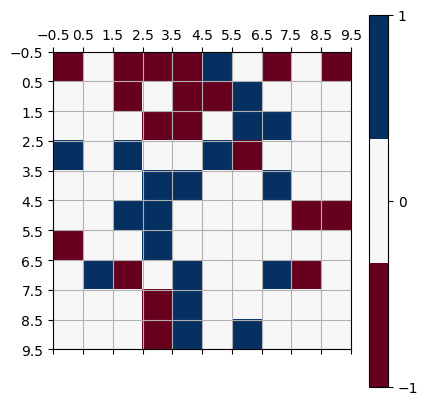

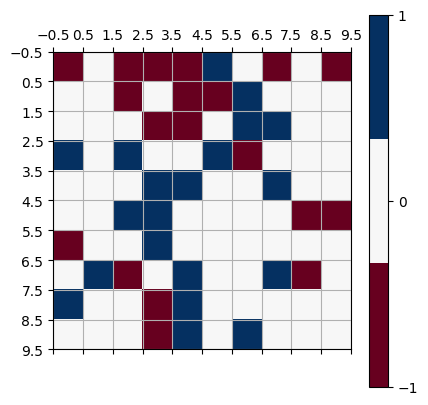

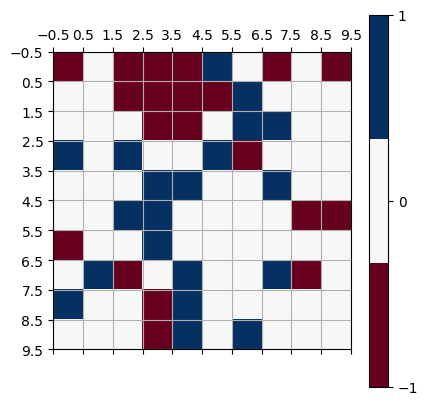

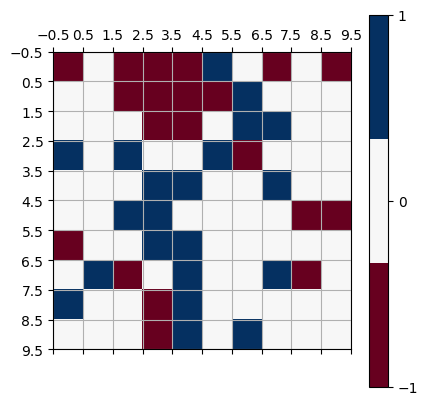

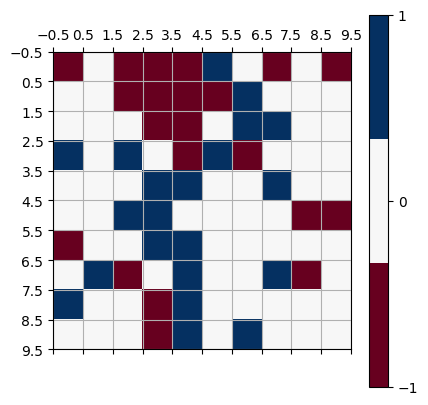

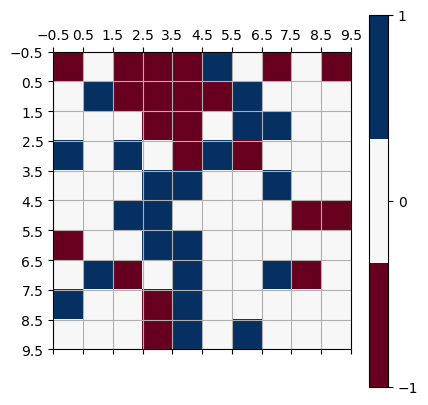

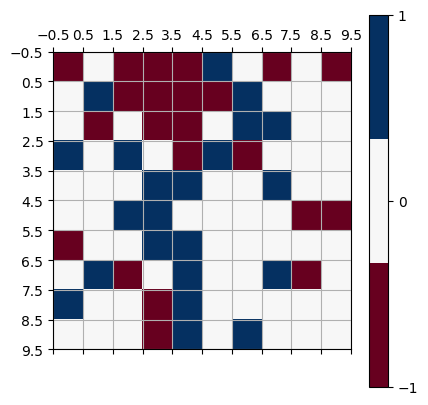

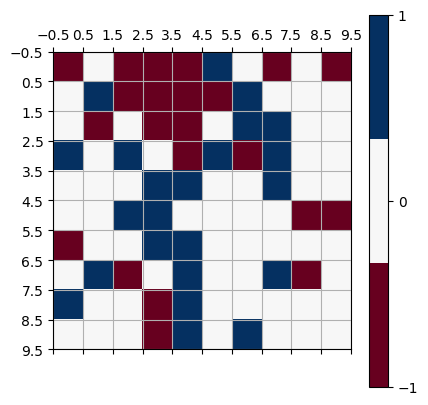

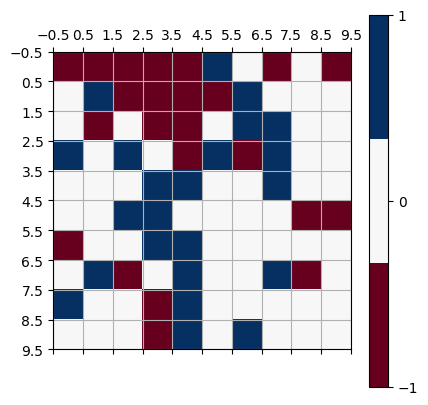

-1

In [78]:
comp_players(h_play,Q_play,show_board=True)

## Other Work

In [90]:
import copy
from tqdm.notebook import tqdm
epochs = 5000
gamma = 0.5
old_score = 0
stable_model = copy.deepcopy(model)
stable_model.eval()

batch_size = 50
batch = list()
lab = list()
for e in tqdm(range(epochs)):
    #get action according to the boltzman distribution
    move,moves = game.sample_action(model,T=250/(e+1)**0.5)
    a = moves[move]
    x = game.prepare_input(moves,move)
    game.play(a)
    new_score = game.score()
    dif = (new_score-old_score)
    #print(dif)
    #heuristic player play
    move, old_score = h_player(game)
    game.play(move)
    if game.check_winner()!=0:
        Q_star = dif
        game.__init__()
        old_score = 0
    else:
        if e > -100:
            Q_star = dif + gamma*game.max_Q(stable_model)
        else:
            Q_star = dif
    batch.append(x)
    lab.append(torch.tensor([Q_star],dtype=torch.float32))
    if e%batch_size == 0:
        #update model
        optimizer.zero_grad()
        Q = model(torch.stack(batch))
        loss = loss_fn(Q, torch.stack(lab))
        loss.backward()
        # Adjust learning weights
        optimizer.step()
        batch = list()
        lab = list()
    if e % 100:
        stable_model = copy.deepcopy(model)
        stable_model.eval()
torch.save(model.state_dict(), 'RL.pth')

  0%|          | 0/5000 [00:00<?, ?it/s]

In [91]:
moves = game.get_moves()
scores = np.zeros(len(moves))
for i in range(len(moves)):
    x = game.prepare_input(moves,i)
    scores[i] = model(x.unsqueeze(0)).item()
print(scores)

[66.54711914 57.18320084 46.03944778 55.40336609 46.03944778 66.54711914
 57.18320084 55.40336609 55.40336609 46.03944778]


In [79]:
pars = [p for p in model.parameters()]

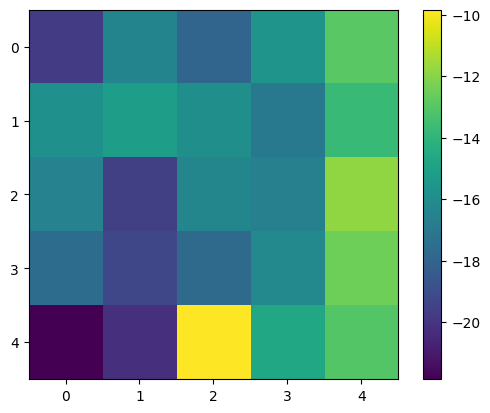

In [84]:
import matplotlib.pyplot as plt
plt.imshow(pars[0][1,0].detach())
plt.colorbar()